In [116]:
import pandas as pd
import json
from sklearn import cross_validation, linear_model, grid_search
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

import pdb

## when working in Py3
# import sys, os; sys.path.append(os.path.abspath("..")) # call Py module from parent dir
# from fetch_data import FetchData 

### base notebook from Marcus & Metis course

# Read in data

In [193]:
with open('../data/peppers_20171013.json') as json_data:
    data = json.load(json_data, encoding="utf-8")
peppers = pd.DataFrame(data["peppers"])
peppers.sample(3)

,heat,link,max_jrp,max_shu,min_jrp,min_shu,name,origin,region,species
26,mild,http://www.pepperscale.com/holy-mole-pepper,-3,800,-10,700.0,Holy Mole Pepper,United States,North America,annuum
14,mild,http://www.pepperscale.com/pepperoncini,-5,500,-80,100.0,Pepperoncini,Italy,Europe,annuum
13,mild,http://www.pepperscale.com/shishito-pepper,-13,200,-160,50.0,Shishito Pepper,Japan,Asia,annuum


# Visualize features

Plot the relationships between min & max JRP & SHU

Number of features: 4


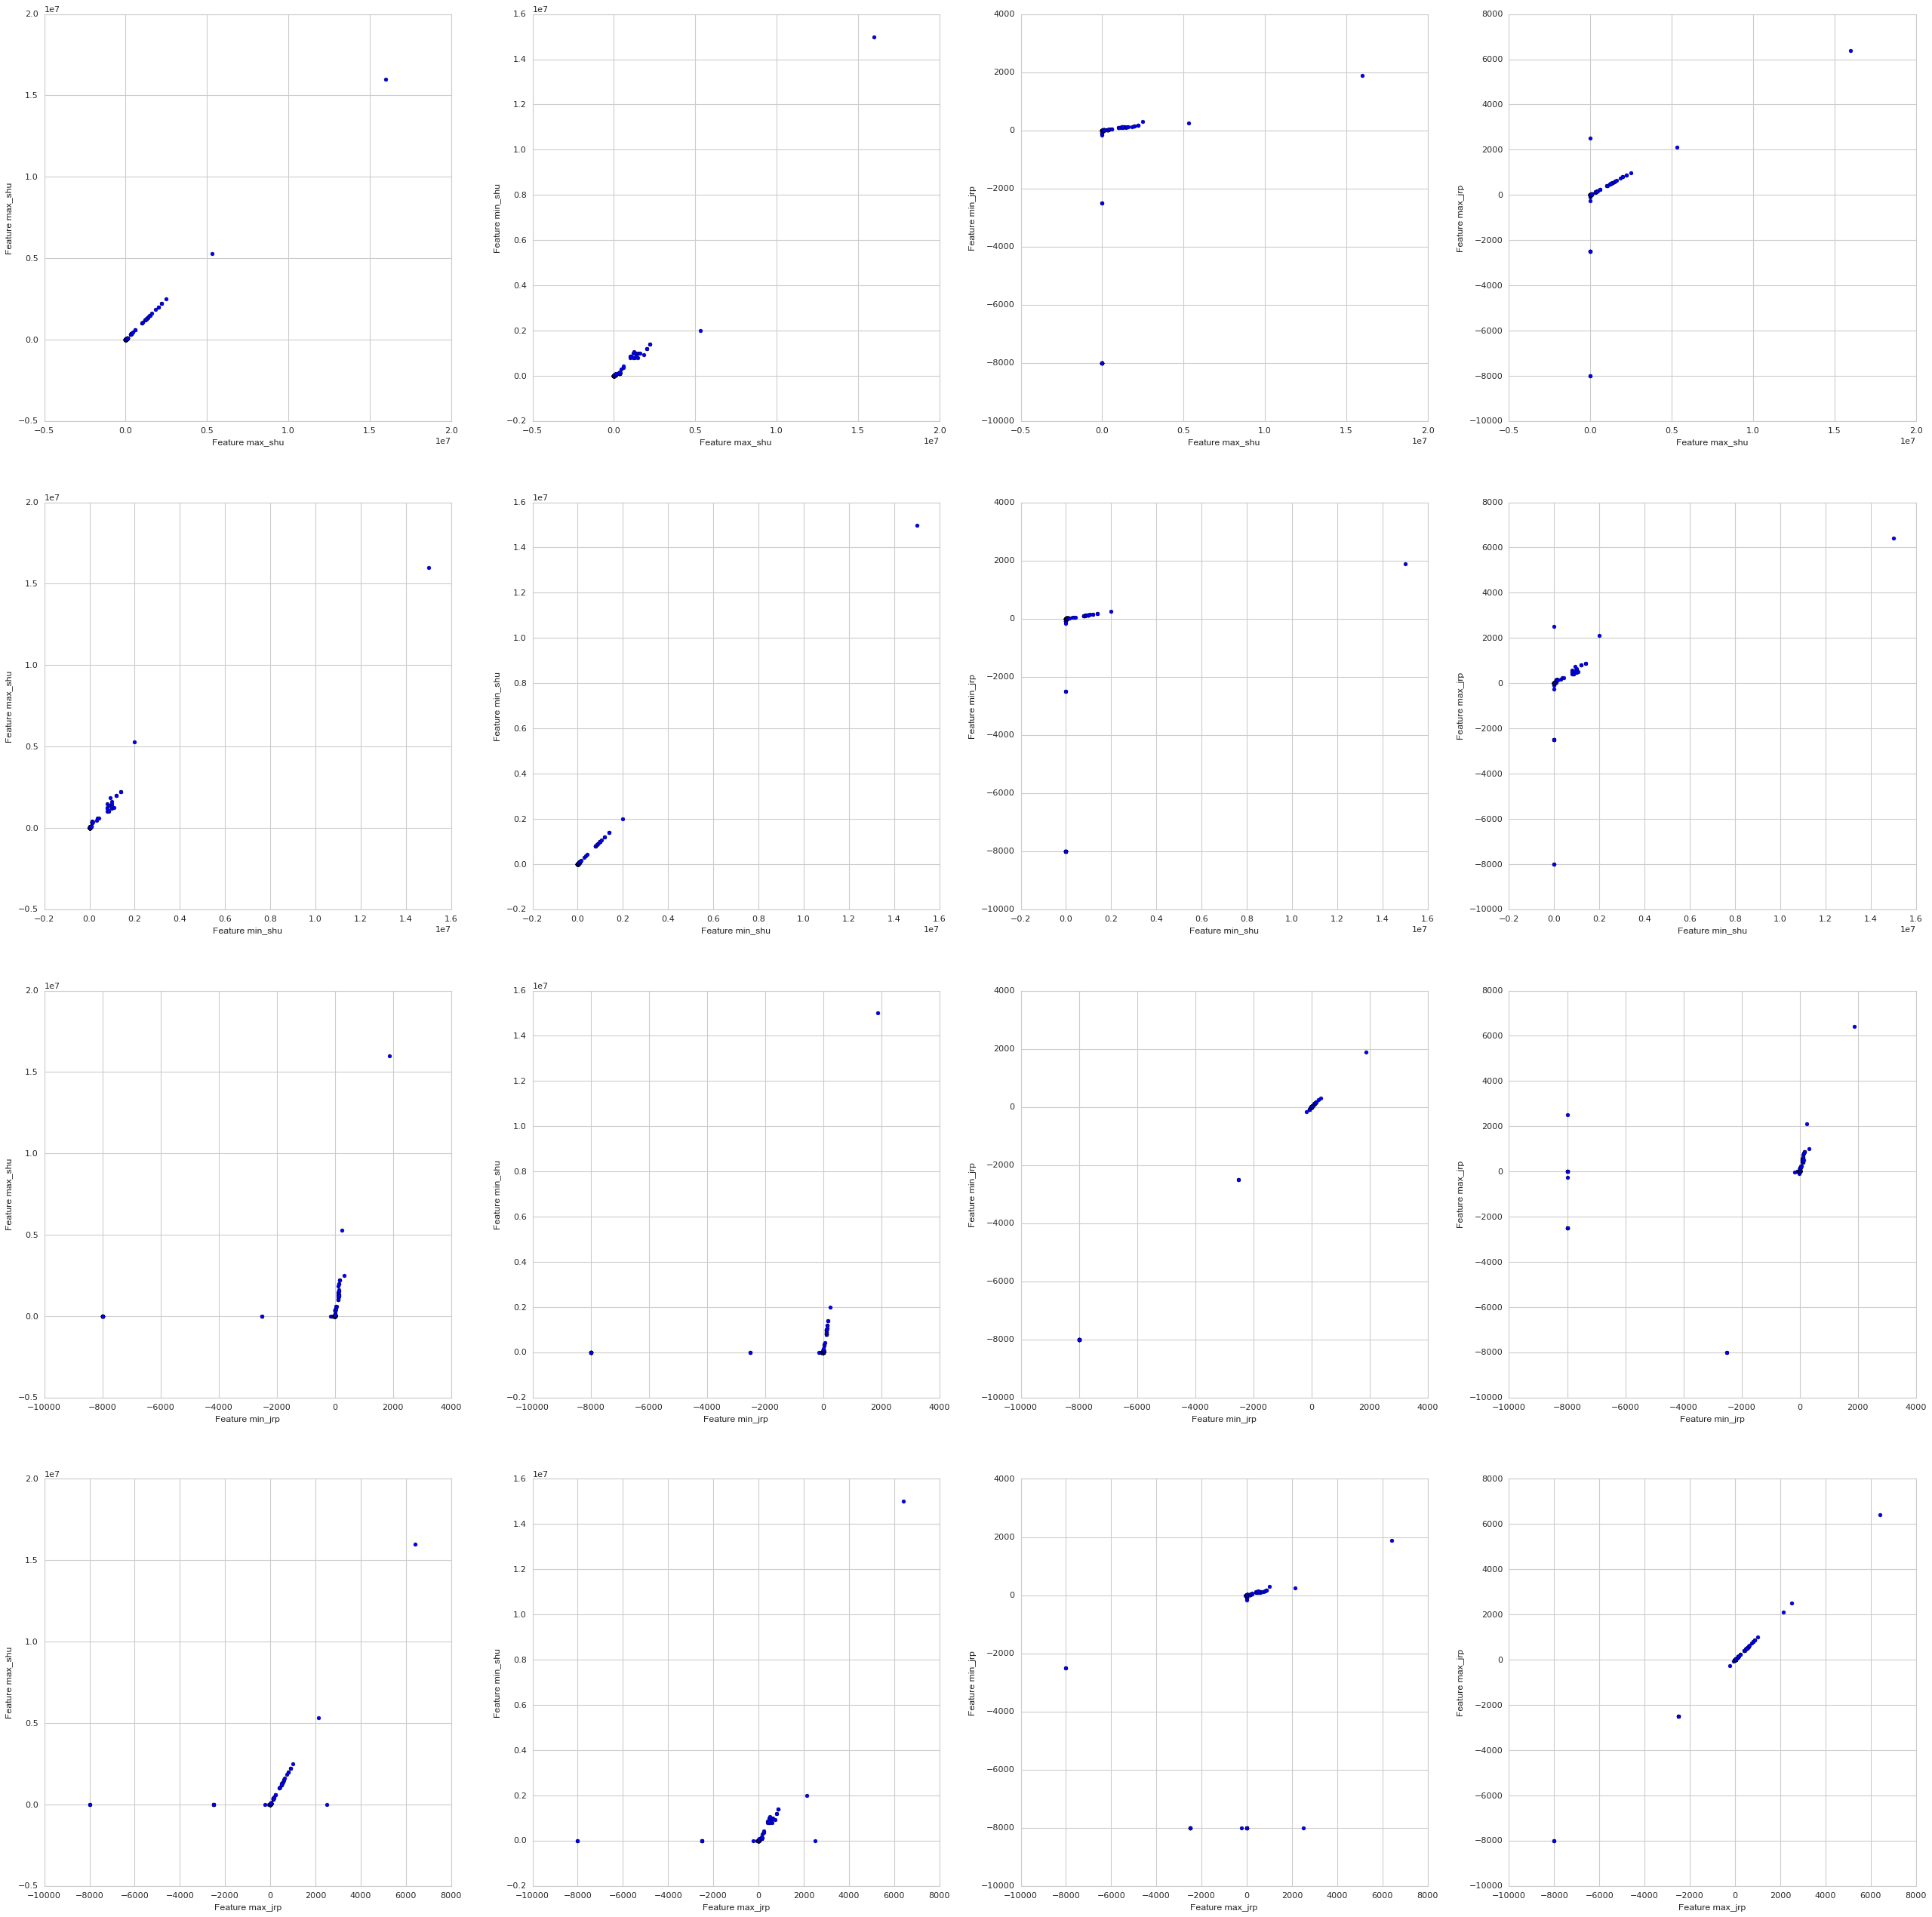

In [187]:
## visualize the relationships between SHU & JRP

features = ["max_shu", "min_shu", "min_jrp", "max_jrp"]

def scatter_matrix(data, features=features):
    feature_count = len(features)
    print "Number of features:", feature_count
    
    fig,ax = plt.subplots(ncols=feature_count,
                          nrows=feature_count,
                          figsize=(10*feature_count, 10*feature_count))

    feature_data = data[features]
    for index_x, feature_x in enumerate(feature_data):
        for index_y, feature_y in enumerate(feature_data):
            ax[index_x][index_y].scatter(data[feature_x], data[feature_y])
            ax[index_x][index_y].set_ylabel('Feature ' + str(feature_y))
            ax[index_x][index_y].set_xlabel('Feature ' + str(feature_x))
            
scatter_matrix(peppers)

## Scatter insights

When comparing min SHU & min JRP and max SHU & max JRP, there are clear outliers around 0 SHU. Otherwise, the relationship is visually well described linearly.

#### Hypothesis
The relationship between JRP and SHU can be represented by a linear regression model when scrubbing the data for outliers at the 0 SHU mark.

# Clean data
Get rid of outliers to scrub the noise from the data and find the line

Resources:
- http://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/

In [195]:
clean_peppers = peppers[(peppers["max_shu"] != 0) & ~(peppers["min_shu"].isnull()) & 
                        (peppers["min_shu"] != 0)][features]
peppers.shape, clean_peppers.shape

((122, 10), (110, 4))

In [200]:
clean_peppers.sort_values(features).drop_duplicates().sort_values("min_shu").head(10)
# -8000 is also an outlier that's affecting the regression

,max_shu,min_shu,min_jrp,max_jrp
11,1000,1.0,-8000,-3
12,1000,1.0,-8000,-2
13,200,50.0,-160,-13
14,500,100.0,-80,-5
16,1000,100.0,-80,-3
18,1000,100.0,-3,-80
22,4000,500.0,-16,0
21,2500,500.0,-16,0
25,4000,500.0,-5,0
19,1000,500.0,-16,-3


In [201]:
clean_peppers = clean_peppers[clean_peppers["min_jrp"] != -8000]
peppers.shape, clean_peppers.shape

((122, 10), (108, 4))

# Set up models

Resources: 
- http://scikit-learn.org/stable/modules/linear_model.html
- https://www.datasciencecentral.com/profiles/blogs/10-types-of-regressions-which-one-to-use


In [204]:
def reshape_values(data):
    return data.values.reshape((len(data), 1))

# set up popular regression models
models = {}
models['ols'] = linear_model.LinearRegression()
models['ridge'] = linear_model.Ridge()
models['lasso'] = linear_model.Lasso(alpha=.002)
models['elasticnet'] = linear_model.ElasticNet()

coefficients = {}

def run_model(model_name="elasticnet", cols=["min_shu", "min_jrp"], plot=True):
    predictor_col, target_col = cols
    
    # shape JRP and SHU values
    predictors = reshape_values(clean_peppers[predictor_col])
    target = reshape_values(clean_peppers[target_col])

    # split dataset into train and test
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(predictors, target, test_size=0.1)

    # run
    print(model_name)
    model = models[model_name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Model: '+ model_name)
    print("Score: " + str(model.score(X_test, y_test)))
    print("MSqE: " + str(mean_squared_error(y_test, y_pred)))
    print("R^2: " + str(r2_score(y_test, y_pred)))
    result = "Result: {} = {} * {}".format(target_col, predictor_col, model.coef_)
    print(result)
    
    # keep track of coefficients for later sanitization
    coefficients["{} X {}".format(predictor_col, target_col)] = model.coef_
    
    if plot:
        generate_regression_plot(model.coef_, cols, title=result)
        
plot_params = {
    "min_shu": {"lim": (-0.2*10**7, 1.6*10**7), "ticks": range(int(-0.2*10**7), int(1.7*10**7), int(0.2*10**7))},
    "min_jrp": {"lim": (-400, 2200), "ticks": range(-400, 2300, 200)},
    "max_shu": {"lim": (-0.2*10**7, 1.6*10**7), "ticks": range(int(-0.2*10**7), int(2.0*10**7), int(0.2*10**7))},
    "max_jrp": {"lim": (-500, 6500), "ticks": range(-500, 6600, 500)}
}

def generate_regression_plot(coefficients, cols=["min_shu", "min_jrp"], title=""):
    predictor_col, target_col = cols

    # generate best fit line data
    slope = coefficients # to alter if model ever produces y-intercept value
    best_fit_line = slope * range(0, int(max(clean_peppers[predictor_col])), 1)

    plot_title = title.replace("Result: ", "") + "\n"
    plot = clean_peppers.plot.scatter(x=predictor_col, y=target_col, figsize=(10,10), title=plot_title)
    plt.plot(best_fit_line, color="green")
    
    plot.set_xlim(plot_params[predictor_col]["lim"])
    plot.set_xticks(plot_params[predictor_col]["ticks"])
    plot.set_ylim(plot_params[target_col]["lim"])
    plot.set_yticks(plot_params[target_col]["ticks"])
    plot.set_xlabel("\n{}".format(predictor_col))
    plot.set_ylabel("{}\n".format(target_col))
    
    return plot

## Min model

elasticnet
Model: elasticnet
Score: 0.864563424943
MSqE: 524.367884819
R^2: 0.864563424943
Result: min_jrp = min_shu * [ 0.00012588]


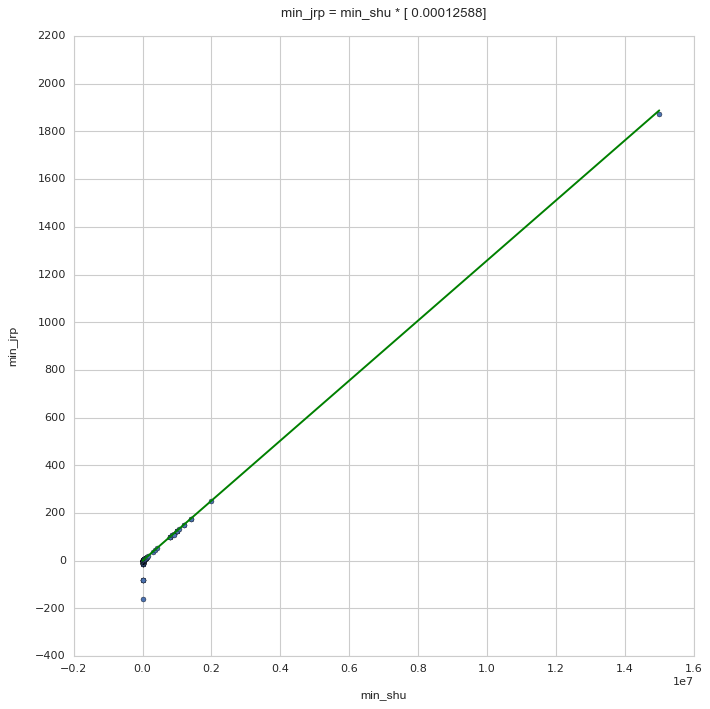

In [205]:
run_model(cols=["min_shu", "min_jrp"])

elasticnet
Model: elasticnet
Score: 0.720546313776
MSqE: 32654141294.7
R^2: 0.720546313776
Result: min_shu = min_jrp * [ 7850.13794846]


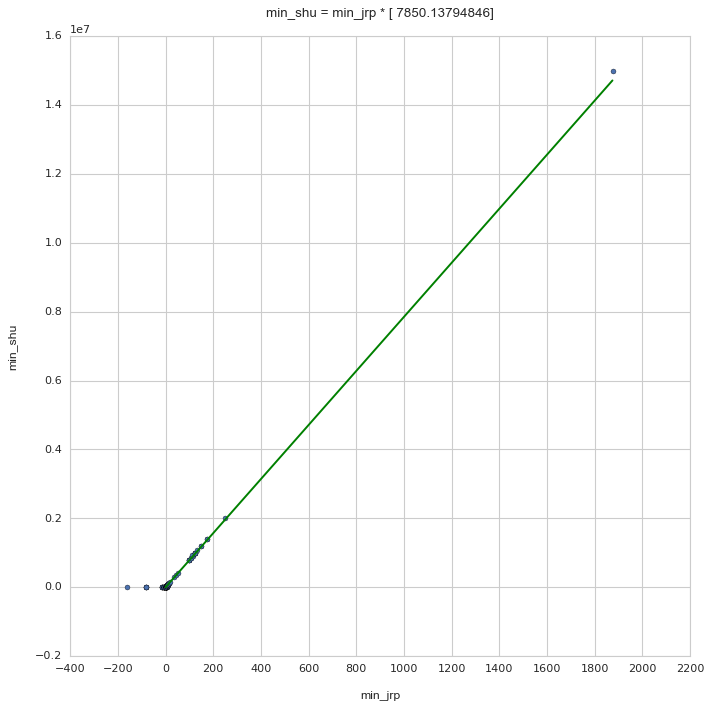

In [206]:
run_model(cols=["min_jrp", "min_shu"])

## Max model

elasticnet
Model: elasticnet
Score: 0.999949756389
MSqE: 3.39725788772
R^2: 0.999949756389
Result: max_jrp = max_shu * [ 0.00040032]


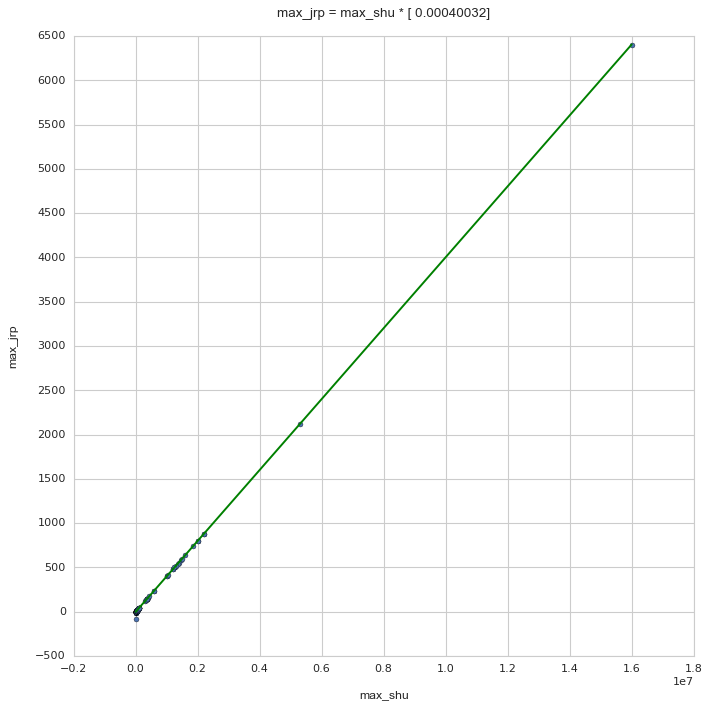

In [207]:
run_model(cols=["max_shu", "max_jrp"])

elasticnet
Model: elasticnet
Score: 0.987381567698
MSqE: 3568495114.01
R^2: 0.987381567698
Result: max_shu = max_jrp * [ 2498.81690116]


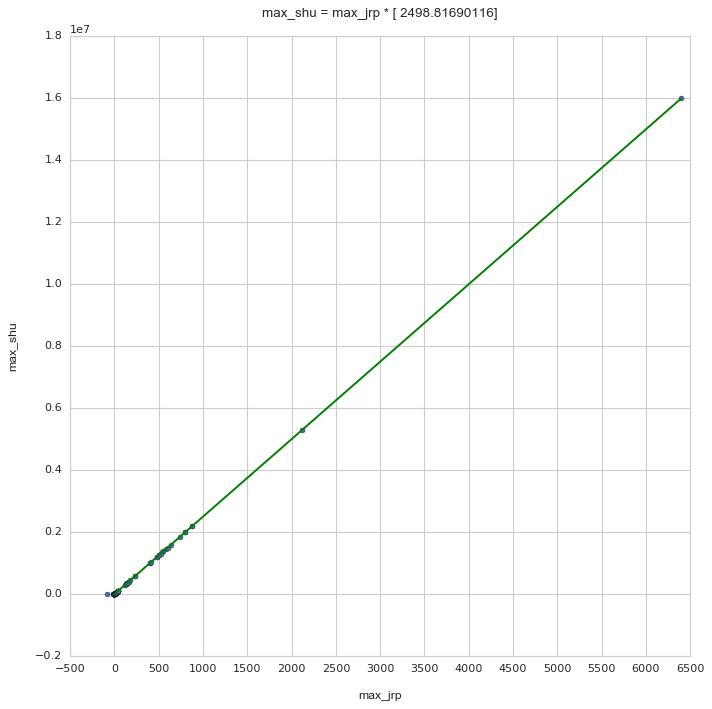

In [208]:
run_model(cols=["max_jrp", "max_shu"])

In [ ]:
# extra credit:
# make interactive fit plot
# make residual plot

# Sanitize SHU & JRP values

In [209]:
coefficients

{'max_jrp X max_shu': array([ 2498.81690116]),
 'max_shu X max_jrp': array([ 0.00040032]),
 'min_jrp X min_shu': array([ 7850.13794846]),
 'min_shu X min_jrp': array([ 0.00012588])}